In [412]:
using LinearAlgebra
using SparseArrays
using Plots

In [413]:
struct Rectangle
    center
    halflength::Float64
    halfheight::Float64
end

In [414]:
function onezero(Tx,Ty,shape)
    grid = Tx .* zeros(length(Ty))
    
    for j = 1:size(grid,1)
        for i = 1:size(grid,2)
            grid[j,i] = (abs(Tx[i]-shape.center[1]) <= shape.halflength ) && (abs(Ty[j]-shape.center[2]) <= shape.halfheight ) ? 1 : 0
        end
    end
    
    return grid
end

onezero (generic function with 1 method)

In [415]:
nx = 280
ny = 1;

## construct operators

In [416]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;

In [417]:
Γ = k/(c*ρ);
dt = 1e-4;

inch = 2.54e-2
Lx = 0.1270;
Ly = 0.0648;
dx = Lx/nx
dy = Ly/ny



xfactor = Γ*dt/2/dx^2
yfactor = Γ*dt/2/dy^2;

In [418]:
N = nx*ny
dlx = ones(N-1)
dx  = -2ones(N)
drx = deepcopy(dlx);

dx[1:nx:end] .= -1.0
dx[nx:nx:end] .= -1.0
dlx[nx:nx:end] .= 0.0
drx = dlx;

In [419]:
dly = ones(N-1)
dy  = -2ones(N)
dry = deepcopy(dly);

dy[1:ny:end] .= -1.0
dy[ny:ny:end] .= -1.0
dly[ny:ny:end] .= 0.0
dry = dly;

In [420]:
Fourier = Γ*dt/(Lx/nx)^2

0.03351728905035085

## initial values

In [421]:
Tx = range(0+0.5Lx/nx,Lx-0.5Lx/nx,length=nx)'  # note ': this is a row vector
Ty = range(0+0.5Ly/ny,Ly-0.5Ly/ny,length=ny)

p = 2

Tvalue =  @. 1 * cos(p*pi*Tx/Lx) +  0* cos(p*pi*Ty/Ly);
Texact(t) = exp(-Γ*(p*π/Lx)^2*t)*Tvalue';



# σ = 0.01 # width of pulse
# A = 10.0 * 0 # strength (easy to set to 0 if you don't want to do this problem)
# Tvalue =  @. A*exp(-((Tx-Lx/2)^2+(Ty-Ly/2)^2)/σ^2);

In [422]:
Tvecy = vcat(Tvalue...);
Tvecx = vcat(transpose(Tvalue)...);

In [423]:
Tx

1×280 Adjoint{Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}:
 0.000226786  0.000680357  0.00113393  …  0.125866  0.12632  0.126773

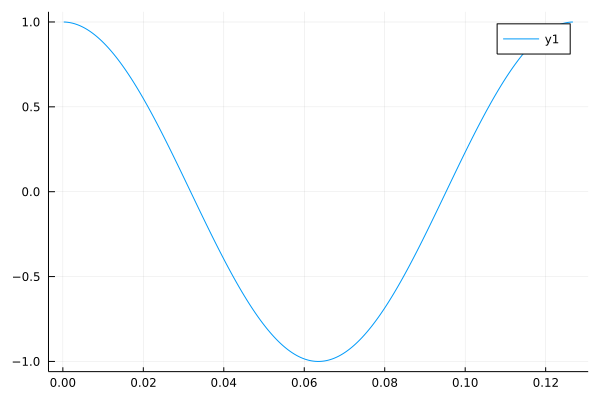

In [424]:
plot(Tx',Tvalue')

In [425]:
DDx = xfactor*Tridiagonal(dlx,dx,drx)
DDy = yfactor*Tridiagonal(dly,dy,dry)

@time DDTx = DDx*Tvecx
@time DDTy = DDy*Tvecy


T2Dx = reshape(DDTx,nx,ny)'
T2Dy = reshape(DDTy,ny,nx);

  0.000010 seconds (1 allocation: 2.312 KiB)
  0.000008 seconds (1 allocation: 2.312 KiB)


## Add a rectangular heater with constant power

In [426]:
fact = 1.0/(c*ρ*d)

0.00020644948181180065

In [427]:
shape1 = Rectangle((0.5Lx-0.7inch,0.5Ly),0.5inch,0.45Ly)
shape2 = Rectangle((0.5Lx+0.7inch,0.5Ly),0.5inch,0.45Ly)
shapeheater = [shape1;shape2]
qe = 15500.0*0.0
heatflux = fact * qe

0.0

In [428]:
heatergrid = sum(onezero.([Tx],[Ty],shapeheater))
qheatervec = heatflux .* heatergrid[:];

In [429]:
maximum(qheatervec)

0.0

## Add a rectangular condenser with constant temprature

In [430]:
shape3 = Rectangle((0.5Lx - 2.5inch,0.5Ly),0.25inch,0.45Ly)
shape4 = Rectangle((0.5Lx + 2.5inch,0.5Ly),0.25inch,0.45Ly)


shapecond =  [shape3;shape4]

hc = 2000.0*0.0
Tc = 0.0

hfact = fact * hc

0.0

In [431]:
condensergrid = sum(onezero.([Tx],[Ty],shapecond))
condenservec =  condensergrid[:];

## derive results

In [432]:
num = 10000
ΔN = 100

Thist = []
Tlast = deepcopy(Tvecy)

push!(Thist,Tvecy)

@time for i = 1:num
    
 
    Told = deepcopy(Tlast)
    

        T2Dold = reshape((I + DDy)*Told,ny,nx)
        Tvecold = transpose(T2Dold)[:]
        Ttemp = (I - DDx)\Tvecold
    
    
        qcondvec = hfact .* (Tc .- Told) .* condenservec
    
    

        T2Dtemp= reshape((I + DDx)*Ttemp,nx,ny)
        Tvectemp = transpose(T2Dtemp)[:];
#         Tnew  = (I - DDy)\Tvectemp
        Tnew  = (I - DDy)\Tvectemp + dt .* (qheatervec + qcondvec)
        
        Tlast = Tnew
    
    if mod(i,ΔN) == 0
        push!(Thist,Tnew)
    end

end

  0.427411 seconds (568.98 k allocations: 734.392 MiB, 17.06% gc time)


In [433]:
T2Dhist = reshape.(Thist,ny,nx);

In [434]:
length(T2Dhist)

101

## plot results

In [435]:
maximum(T2Dhist[end])

0.8308932167715893

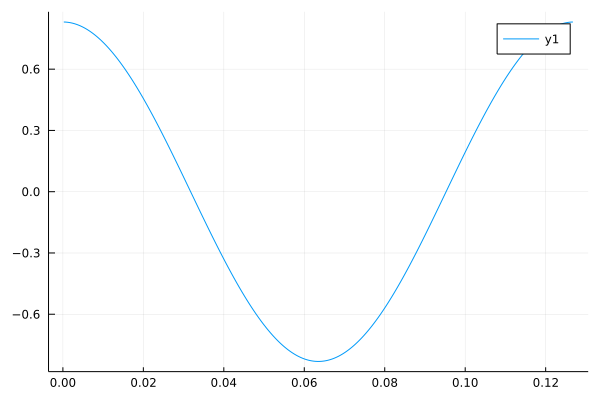

In [436]:
plot(Tx',T2Dhist[end]')

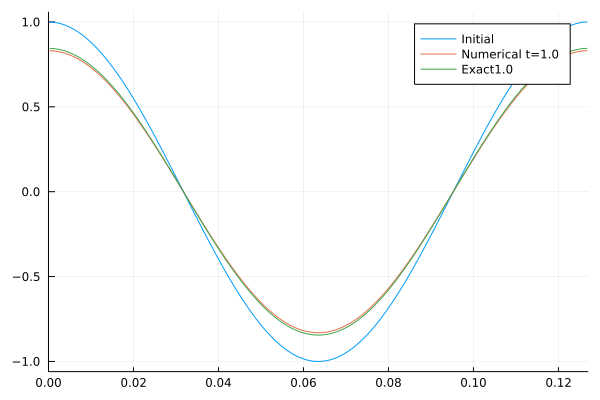

In [437]:
t = dt*num
plot(Tx',Tvalue',label="Initial",xlims=(0,Lx))
plot!(Tx',T2Dhist[end]',label="Numerical t="*string(round(t,digits=3)))
plot!(Tx',Texact(t),label="Exact"*string(round(t,digits=3)))

In [438]:
b = rand(10)
A = rand(10,10)


10×10 Array{Float64,2}:
 0.263069    0.151722   0.51543     …  0.542692   0.300491  0.113258
 0.00350549  0.383256   0.213365       0.772335   0.185146  0.903181
 0.881847    0.844781   0.163278       0.449028   0.361066  0.996218
 0.185024    0.534439   0.966196       0.0358332  0.97001   0.916678
 0.317026    0.196393   0.610829       0.980126   0.337593  0.445092
 0.590065    0.780631   0.836341    …  0.59855    0.32175   0.804181
 0.00926178  0.0181625  0.168139       0.282468   0.942747  0.377619
 0.813816    0.450149   0.24377        0.307559   0.839665  0.821378
 0.697452    0.785894   0.710042       0.286089   0.867944  0.449755
 0.936684    0.140941   0.00344462     0.461605   0.302648  0.997135

In [439]:
# @gif for i=1:length(T2Dhist)
    
#     plot(T2Dhist[i][1,:])
    
# end

In [440]:
T2Dy

1×280 Array{Float64,2}:
 -8.21018e-7  -8.20605e-7  -8.19778e-7  …  -8.20605e-7  -8.21018e-7

In [441]:
T2Dx

1×280 Adjoint{Float64,Array{Float64,2}}:
 -8.43795e-6  -8.4337e-6  -8.42521e-6  …  -8.4337e-6  -8.43795e-6

In [442]:
fourier = 

LoadError: [91msyntax: incomplete: premature end of input[39m

In [443]:
T

LoadError: [91mUndefVarError: T not defined[39m